In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy
import tensorflow as tf
from tensorflow.keras.layers import Reshape, Multiply
import cv2
import numpy as np

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mariaherrerot/aptos2019")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'aptos2019' dataset.
Path to dataset files: /kaggle/input/aptos2019


In [ ]:
unbalanced_data_path = path+'/train_images/train_images'

In [ ]:
y_true = pd.read_csv(path+'/train_1.csv')
y_true['id_code'] = y_true['id_code'].map(lambda x: x + '.png' if not x.endswith('.png') else x)
y_true.head()

,id_code,diagnosis
0,1ae8c165fd53.png,2
1,1b329a127307.png,1
2,1b32e1d775ea.png,4
3,1b3647865779.png,0
4,1b398c0494d1.png,0


In [ ]:
y_true['diagnosis']=y_true['diagnosis'].astype(str)
y_true.head()

,id_code,diagnosis
0,1ae8c165fd53.png,2
1,1b329a127307.png,1
2,1b32e1d775ea.png,4
3,1b3647865779.png,0
4,1b398c0494d1.png,0


In [ ]:
def image_resize(image):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image=cv2.resize(image,(255,255))
  image=image/255.0
  return image

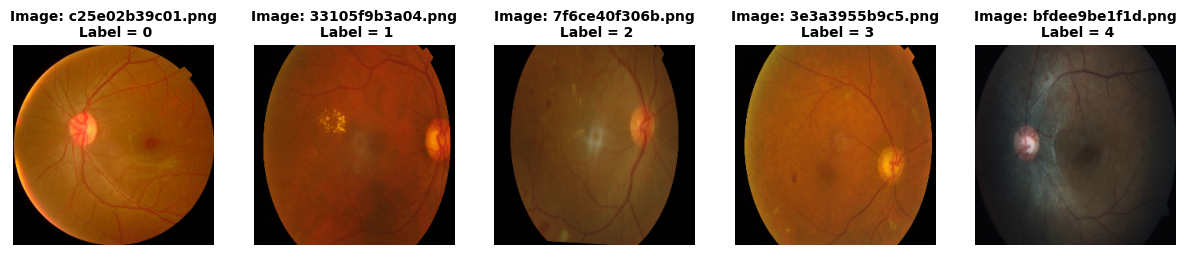

In [ ]:
train_df = pd.read_csv(path+'/train_1.csv')
train_df['id_code'] = train_df['id_code'].map(lambda x: x + '.png' if not x.endswith('.png') else x)


fig, ax = plt.subplots(1, 5, figsize=(15, 6))
for i in range(5):
    sample = train_df[train_df['diagnosis'] == i].sample(1)
    image_name = sample['id_code'].item()
    X = image_resize(cv2.imread(f"{unbalanced_data_path}/{image_name}"))
    ax[i].set_title(f"Image: {image_name}\n Label = {sample['diagnosis'].item()}",
                    weight='bold', fontsize=10)
    ax[i].axis('off')
    ax[i].imshow(X);

In [ ]:
train_df['diagnosis']=train_df['diagnosis'].astype(str)

train_datagen = ImageDataGenerator(validation_split=0.10,
                                   preprocessing_function=image_resize)


train_gen = train_datagen.flow_from_dataframe(train_df,
                                                    x_col='id_code',
                                                    y_col='diagnosis',
                                                    directory = unbalanced_data_path,
                                                    target_size=(255,255),
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    subset='training')

val_gen = train_datagen.flow_from_dataframe(train_df,
                                                  x_col='id_code',
                                                  y_col='diagnosis',
                                                  directory = unbalanced_data_path,
                                                  target_size=(255,255),
                                                  batch_size=32,
                                                  class_mode='categorical',
                                                  subset='validation')

Found 2637 validated image filenames belonging to 5 classes.
Found 293 validated image filenames belonging to 5 classes.


In [ ]:
classes = np.unique(train_df['diagnosis'])
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_df['diagnosis'])
class_weight_dict = dict(zip(classes, class_weights))

print("Calculated Class Weights:", class_weight_dict)

Calculated Class Weights: {'0': np.float64(0.4086471408647141), '1': np.float64(1.9533333333333334), '2': np.float64(0.7252475247524752), '3': np.float64(3.8051948051948052), '4': np.float64(2.5042735042735043)}


## Load Pre-trained InceptionV3 Model



In [ ]:
from tensorflow.keras.applications import InceptionV3

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(255, 255, 3))
print("Pre-trained InceptionV3 model loaded successfully.")

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Pre-trained InceptionV3 model loaded successfully.


## Modify Model for Transfer Learning



In [ ]:
for layer in base_model.layers:
    layer.trainable = False

inputs = Input(shape=(255, 255, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
outputs = Dense(5, activation='softmax')(x)

model = Model(inputs, outputs)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 255, 255, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 6, 6, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_94          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_95          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,337,829 (85.21 MB)

 Trainable params: 530,437 (2.02 MB)

 Non-trainable params: 21,807,392 (83.19 MB)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Implement Grad-CAM Function



In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last convolutional layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last convolutional layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen) with respect to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array by "how important this channel is" with respect to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

print("Grad-CAM function 'make_gradcam_heatmap' defined.")

Grad-CAM function 'make_gradcam_heatmap' defined.


## Train the Model



In [ ]:
def lr_schedule_exp(epoch):
  if epoch<4:
    return float(tf.exp(-epoch/10.)*0.01)/2
  elif epoch<8:
    return float(tf.exp(-epoch/10.)*0.01)/3
  else:
    return float(tf.exp(-epoch/10.)*0.01)/4


schedule_4=tf.keras.callbacks.LearningRateScheduler(lr_schedule_exp)
check_point_4=tf.keras.callbacks.ModelCheckpoint('model_4_best.keras',monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3,verbose=1,restore_best_weights=True,mode='max')

In [ ]:
history = model.fit(train_gen,
                    epochs=10,
                    validation_data=val_gen,
                    class_weight=class_weight_dict,callbacks=[schedule_4,check_point_4,early_stop])

Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8191 - loss: 0.5444
Epoch 1: val_accuracy improved from -inf to 0.72355, saving model to model_4_best.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 313s 4s/step - accuracy: 0.8187 - loss: 0.5457 - val_accuracy: 0.7235 - val_loss: 0.7152 - learning_rate: 0.0050
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8730 - loss: 0.3414
Epoch 2: val_accuracy improved from 0.72355 to 0.75768, saving model to model_4_best.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 292s 4s/step - accuracy: 0.8730 - loss: 0.3416 - val_accuracy: 0.7577 - val_loss: 0.7783 - learning_rate: 0.0045
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9323 - loss: 0.2057
Epoch 3: val_accuracy improved from 0.75768 to 0.76792, saving model to model_4_best.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 291s 4s/step - accuracy: 0.9322 - loss: 0.2057 - val_accuracy: 0.7679 - val_loss: 0.7389 - learning_rate: 0.0041
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 

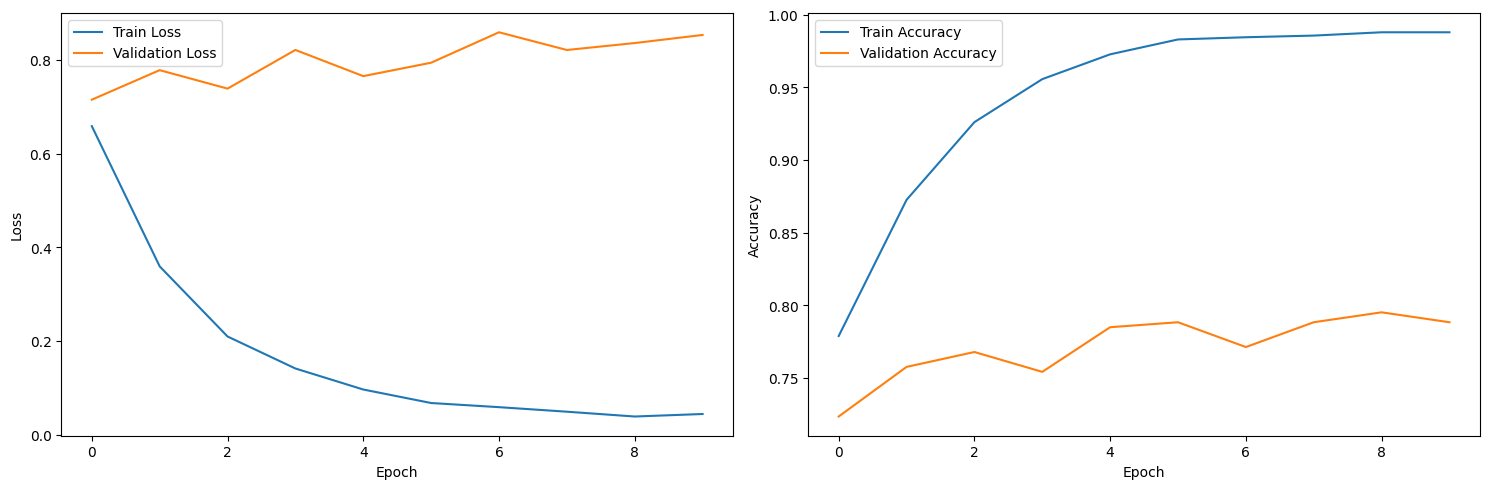

In [ ]:
fig,axes=plt.subplots(1,2,figsize=(15,5))

axes[0].plot(history.history['loss'],label='Train Loss')
axes[0].plot(history.history['val_loss'],label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(history.history['accuracy'],label='Train Accuracy')
axes[1].plot(history.history['val_accuracy'],label='Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()

In [ ]:
predictions=model.predict(val_gen)
predictions=np.argmax(predictions,axis=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 44s 4s/step


<Axes: >

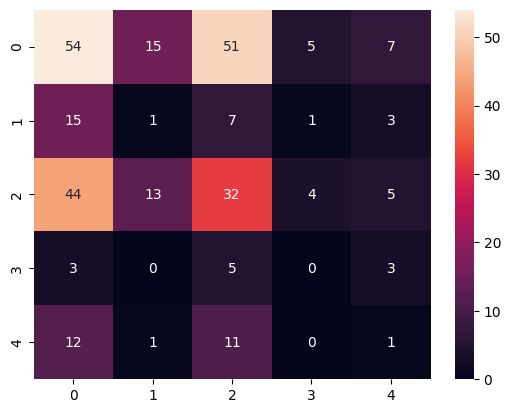

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
sns.heatmap(confusion_matrix(val_gen.classes,predictions),annot=True,fmt='d')

In [ ]:
print(classification_report(val_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.42      0.41      0.42       132
           1       0.03      0.04      0.04        27
           2       0.30      0.33      0.31        98
           3       0.00      0.00      0.00        11
           4       0.05      0.04      0.05        25

    accuracy                           0.30       293
   macro avg       0.16      0.16      0.16       293
weighted avg       0.30      0.30      0.30       293



In [ ]:
selected_images_for_heatmap = []
unique_diagnoses = train_df['diagnosis'].unique()

for diagnosis_label in sorted(unique_diagnoses):
    sample_image = train_df[train_df['diagnosis'] == diagnosis_label].sample(1)
    selected_images_for_heatmap.append({
        'id_code': sample_image['id_code'].item(),
        'diagnosis': sample_image['diagnosis'].item()
    })

selected_images_df = pd.DataFrame(selected_images_for_heatmap)
print("Selected images for heatmap generation:")
print(selected_images_df)

Selected images for heatmap generation:
            id_code diagnosis
0  33b91def2035.png         0
1  7b20210d9120.png         1
2  2bd4d4fbed5c.png         2
3  bb7e0a2544cd.png         3
4  6630f8675a97.png         4


**Reasoning**:
With the `get_img_array` function now correctly returning a `tf.Tensor`, I will re-execute the code to generate and display the Grad-CAM heatmaps. This should resolve the `KeyError` and allow the visualization of the model's focus areas for each diagnosis category as required by the subtask.

